In [1]:
%matplotlib inline

from collections import namedtuple
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import pandas as pd
from pypika import functions as fn
from pypika import Criterion, Query, Table
import sqlite3

figsize(12.5, 4)

In [2]:
conn = sqlite3.connect('data/search3.db')

In [3]:
list(conn.execute(str(Query.from_('tweets').select(fn.Count('*')))))

[(163224,)]

In [4]:
from pypika.terms import Function

class Substr(Function):
    def __init__(self, term, start, stop, alias=None):
        super(Substr, self).__init__('SUBSTR', term, start, stop, alias=alias)

class DateTrunc(Function):
    UNIT_TO_SUBSTR_STOP = {
        '10 minutes': 17,
        '1 hour': 14,
    }
    
    def __init__(self, date_str, unit='10 minutes', alias=None):
        stop = DateTrunc.UNIT_TO_SUBSTR_STOP[unit]
        super(DateTrunc, self).__init__('SUBSTR', date_str, 0, stop, alias=alias)    

In [38]:
tweets, users = Table('tweets'), Table('users')

In [6]:
TweetSummary = namedtuple('TweetSummary', ['created_at', 'count'])

def tweet_summary(term, truncated_by='10 minutes'):
    s = Query.from_(tweets) \
    .select(
        DateTrunc(tweets.created_at, truncated_by, 'truncated_by'),
        fn.Count(tweets.id)) \
    .where(tweets.text.like(term)) \
    .groupby('truncated_by')

    return [TweetSummary._make(r) for r in conn.execute(str(s))]

In [7]:
df = pd.DataFrame(data=tweet_summary('%緊急事態宣言%'))
df_ = pd.DataFrame(data=tweet_summary('%ロックダウン%'))
df['created_at'] = pd.to_datetime(df['created_at'], format='%a %b %d  %H:%M')
df_['created_at'] = pd.to_datetime(df_['created_at'], format='%a %b %d  %H:%M')
df['count2'] = df_['count']
df = df.set_index('created_at', drop=False)
df.head()

,created_at,count,count2
created_at,,,
1900-03-30 06:32:00,1900-03-30 06:32:00,1,59.0
1900-03-31 10:30:00,1900-03-31 10:30:00,74,70.0
1900-03-31 10:31:00,1900-03-31 10:31:00,100,82.0
1900-03-31 10:32:00,1900-03-31 10:32:00,100,61.0
1900-03-31 10:33:00,1900-03-31 10:33:00,93,80.0


「緊急事態宣言」と「ロックダウン」のツイート数の時系列推移

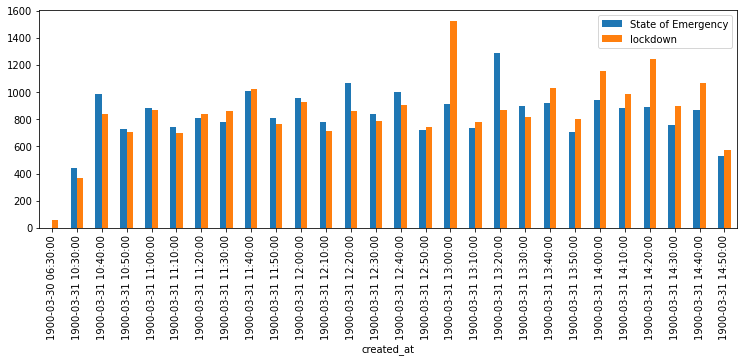

In [10]:
fig, ax = plt.subplots()
df.groupby(df['created_at'].dt.round('10min')).sum().plot(kind='bar', ax=ax)
ax.legend(['State of Emergency', 'lockdown'])

A Field Guide to "Fake News"より、

```
While online and platform metrics often serve to take measure of engagement by
means of what Theodore Porter calls “thin descriptions”[11] – i.e. aggregated
quantities such as total likes, shares, posts – we suggest different ways of
exploring how different publics engage with and ascribe meaning to fake news and
how this moves and mobilises different actors in the process.
```

試しに、retweet 数で足切りした上で、時系列にその tweet を並べてみたい。
まず、retweet 数の分布をしりたい

In [63]:
Tweet = namedtuple('Tweet', ['id', 'retweet_count', 'created_at', 'screen_name'])

def list_tweets(term):
    # retweeted_status が json に埋もれてる…あとで取り出すスクリプト書く
    s = Query.from_(tweets) \
    .join(users) \
    .on(tweets.tweeted_by == users.id) \
    .select(
        tweets.id,
        tweets.retweet_count,
        tweets.created_at,
        users.screen_name) \
    .where(tweets.raw_json.not_like('%retweeted_status%'))
    raw_tweets = [Tweet._make(r) for r in conn.execute(str(s))]
    df = pd.DataFrame(data=raw_tweets)
    df['created_at'] = pd.to_datetime(df['created_at'], format='%a %b %d  %H:%M:%S %z %Y')
    df = df.set_index('created_at', drop=False)
    return df

In [64]:
df = list_tweets('%緊急事態宣言%')
df.head()

,id,retweet_count,created_at,screen_name
created_at,,,,
2020-03-30 08:46:50+00:00,1244546615668379649,188045,2020-03-30 08:46:50+00:00,BakaTonoShimura
2020-03-30 10:58:37+00:00,1244579780722184193,14454,2020-03-30 10:58:37+00:00,junjunmjgirly
2020-03-31 14:52:47+00:00,1245001099926327296,0,2020-03-31 14:52:47+00:00,peach_dango
2020-03-31 14:52:47+00:00,1245001098726739974,0,2020-03-31 14:52:47+00:00,Delta_R
2020-03-31 14:52:48+00:00,1245001104103837696,0,2020-03-31 14:52:48+00:00,osinisukuwareta


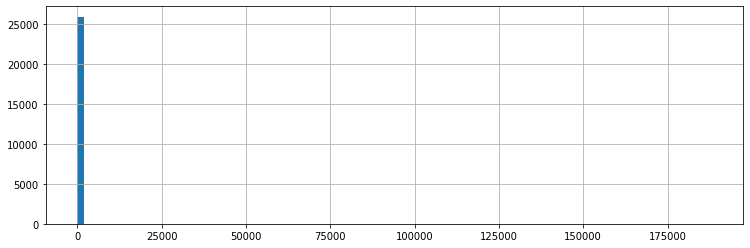

In [65]:
fig, ax = plt.subplots()
df['retweet_count'].hist(ax=ax, bins=100)

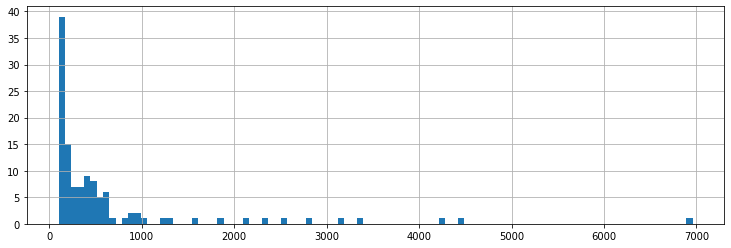

In [75]:
fig, ax = plt.subplots()
df[(100 < df['retweet_count']) & (df['retweet_count'] < 10_000)]['retweet_count'].hist(ax=ax, bins=100)

In [76]:
df.count()

id               25894
retweet_count    25894
created_at       25894
screen_name      25894
dtype: int64

In [77]:
df[df['retweet_count'] > 1_000].count()

id               17
retweet_count    17
created_at       17
screen_name      17
dtype: int64

In [78]:
df[df['retweet_count'] > 1_000]

,id,retweet_count,created_at,screen_name
created_at,,,,
2020-03-30 08:46:50+00:00,1244546615668379649,188045,2020-03-30 08:46:50+00:00,BakaTonoShimura
2020-03-30 10:58:37+00:00,1244579780722184193,14454,2020-03-30 10:58:37+00:00,junjunmjgirly
2020-03-31 13:32:16+00:00,1244980834152484864,1249,2020-03-31 13:32:16+00:00,inugamikorone
2020-03-31 14:01:49+00:00,1244988271337164801,1029,2020-03-31 14:01:49+00:00,katsuyatakasu
2020-03-30 06:32:15+00:00,1244512745484996609,24550,2020-03-30 06:32:15+00:00,YahooNewsTopics
2020-03-31 13:49:15+00:00,1244985107699523584,1278,2020-03-31 13:49:15+00:00,YahooNewsTopics
2020-03-31 12:56:46+00:00,1244971901379727363,4219,2020-03-31 12:56:46+00:00,TE_RUR_ET
2020-03-31 12:31:43+00:00,1244965599375003650,4426,2020-03-31 12:31:43+00:00,ensemble_stars
2020-03-31 12:30:15+00:00,1244965228544053249,3136,2020-03-31 12:30:15+00:00,hoseki_gaoka


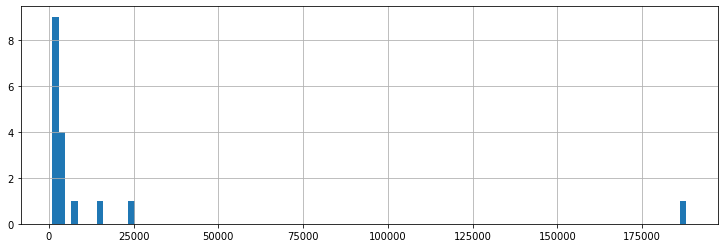

In [79]:
fig, ax = plt.subplots()
df[df['retweet_count'] > 1_000]['retweet_count'].hist(ax=ax, bins=100)

In [84]:
import hashlib

def naive_hash(text):
    return hashlib.sha1(text.encode('utf-8')).hexdigest()

df_gt_1_000_retweets = df[df['retweet_count'] > 1_000]
df_gt_1_000_retweets.drop('id', axis=1, inplace=True)
df_gt_1_000_retweets.loc[:, 'screen_name'] = \
    df_gt_1_000_retweets.loc[:, 'screen_name'].map(naive_hash)

In [85]:
df_gt_1_000_retweets

,retweet_count,created_at,screen_name
created_at,,,
2020-03-30 08:46:50+00:00,188045,2020-03-30 08:46:50+00:00,b470a15eae97c3b27f288d0c1fc7c22ff8b1aa05
2020-03-30 10:58:37+00:00,14454,2020-03-30 10:58:37+00:00,5c10945a3664104863a171deae76279022980f7a
2020-03-31 13:32:16+00:00,1249,2020-03-31 13:32:16+00:00,02116f479ca79460486f223808d7fa626d0b0f08
2020-03-31 14:01:49+00:00,1029,2020-03-31 14:01:49+00:00,dc407606b8099f6dc39e9a14c215ef2c4d9ef569
2020-03-30 06:32:15+00:00,24550,2020-03-30 06:32:15+00:00,086450986c76ec02c1454d0b036418039c96a74e
2020-03-31 13:49:15+00:00,1278,2020-03-31 13:49:15+00:00,086450986c76ec02c1454d0b036418039c96a74e
2020-03-31 12:56:46+00:00,4219,2020-03-31 12:56:46+00:00,574620eaf43f49c1ccce5c610ac2b813d7a75ec3
2020-03-31 12:31:43+00:00,4426,2020-03-31 12:31:43+00:00,4d54d1f53c8051dd0e17521fbd942a40cab014e8
2020-03-31 12:30:15+00:00,3136,2020-03-31 12:30:15+00:00,b897ee31ac93d1f43e13ff602f9220633c97c926


In [86]:
df_gt_1_000_retweets.to_csv('data/over_1_000_retweets.csv')